In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from utils import DataPreprocessing, SpectrogramDataset, plot_waveform, plot_spectrogram, seed_functions

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
ROOT_PATH = os.getcwd()
LOGS_PATH = os.path.join(ROOT_PATH, "logs")
RAW_DATASET_PATH = os.path.join(ROOT_PATH, "dataset", "raw")
PRODUCTION_DATASET_PATH = os.path.join(ROOT_PATH, "dataset", "production")
MODELS_PATH = os.path.join(ROOT_PATH, "models")

print(DEVICE)
seed_functions(SEED)

cuda


Preprocessing

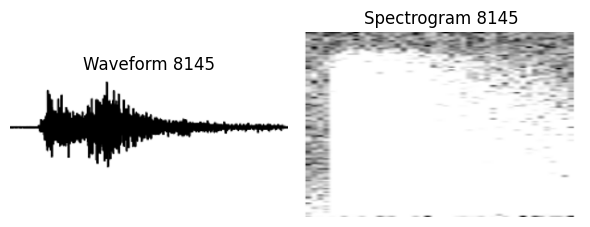

In [2]:
SUBSAMPLE_SIZE = 10000
NOISE_RATIO = 0.5
EARTHQUAKE_RATIO = 0.5

def preprocess_data():
	"""Computes, saves, and prints summary of preprocessed data."""

	# Compute preprocessed data
	data_processor = DataPreprocessing(
		subsample_size=SUBSAMPLE_SIZE,
		raw_dataset_path=RAW_DATASET_PATH,
		logs_path=LOGS_PATH,
		noise_ratio=NOISE_RATIO,
		earthquake_ratio=EARTHQUAKE_RATIO
	)

	# Save preprocessed data
	signals = data_processor.subsample_traces
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"), np.array(list(signals.values())))
	metadata = data_processor.subsample_metadata
	metadata.to_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
	waveform_images = data_processor.create_waveform_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"), waveform_images)
	spectrogram_images = data_processor.create_spectrogram_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"), spectrogram_images)

	# Print summary of preprocessed data
	print(f"""
	1. Expected samples: {SUBSAMPLE_SIZE}
	2. Actual samples: {len(signals)}\n{metadata['category'].value_counts(normalize=True)}
	""")

# preprocess_data()

def visualise_data(num_samples=1):
	"""Randomly selects a pair of waveform and spectrogram images to plot."""

	# Load saved images
	waveform_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"))
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Create figure with subplots
	fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

	# Ensure axes is iterable for a single sample case
	if num_samples == 1:
		axes = [axes]

	# Plot random images
	for i1, i2 in enumerate(np.random.choice(len(waveform_images), num_samples, replace=False)):
		axes[i1][0].imshow(waveform_images[i2])
		axes[i1][0].set_title(f"Waveform {i2}")
		axes[i1][0].axis("off")
		axes[i1][1].imshow(spectrogram_images[i2])
		axes[i1][1].set_title(f"Spectrogram {i2}")
		axes[i1][1].axis("off")
	plt.tight_layout()
	plt.show()

visualise_data()

Loading

In [3]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7

# Load production dataset and compute labels
spectrograms = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))
metadata = pd.read_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
labels = (metadata["category"] == "earthquake").astype(np.float32).values  # 0 (noise), 1 (earthquake)

# Normalize and convert spectrograms and labels to tensors
spectrograms = torch.tensor(spectrograms.astype(np.float32) / 255.0).permute(0, 3, 1, 2)
labels = torch.tensor(labels).view(-1, 1)

def split_data(spectrograms, labels, test_size=0.2, dev_size=0.5):
	train_i, temp_i, train_labels, temp_labels = train_test_split(spectrograms, labels, test_size=test_size, stratify=labels, random_state=SEED)
	dev_i, test_i, dev_labels, test_labels = train_test_split(temp_i, temp_labels, test_size=dev_size, stratify=temp_labels, random_state=SEED)
	return train_i, train_labels, dev_i, dev_labels, test_i, test_labels

# Split production dataset into train, dev, and test sets
train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(spectrograms, labels)

# Convert train, dev, and test sets to train, dev, and test loaders
train_generator = torch.Generator()
train_generator.manual_seed(SEED)
train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)

Training

In [ ]:
from torchvision.models import vit_b_16

class ViTCustom(nn.Module):
	def __init__(self, img_size=(200, 200), patch_size=16):
		super().__init__()
		self.id = self.__class__.__name__
		self.backbone = vit_b_16(weights=None)
		num_patches_w = img_size[0] // patch_size
		num_patches_h = img_size[1] // patch_size
		self.num_patches = num_patches_w * num_patches_h
		self.backbone.conv_proj = nn.Conv2d(
			in_channels=3, out_channels=self.backbone.hidden_dim,
			kernel_size=patch_size, stride=patch_size
		)
		self.backbone.positional_embedding = nn.Parameter(
			torch.randn(1, self.num_patches + 1, self.backbone.hidden_dim)
		)
		self.backbone.heads = nn.Sequential(
			nn.Linear(self.backbone.heads.head.in_features, 1),
			nn.Sigmoid()
		)
	def forward(self, x):
		return self.backbone(x)

In [ ]:
from architectures import *

def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f} - Dev Loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))

		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

model = ViTCustom().to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_model(model, train_loader, dev_loader, criterion, optimizer)

Epoch 1/50 - Train Loss: 0.1839 - Dev Loss: 0.7601
Epoch 2/50 - Train Loss: 0.0602 - Dev Loss: 0.5558
Epoch 3/50 - Train Loss: 0.0371 - Dev Loss: 0.0430
Epoch 4/50 - Train Loss: 0.0277 - Dev Loss: 0.0285
Epoch 5/50 - Train Loss: 0.0224 - Dev Loss: 0.0406
Epoch 6/50 - Train Loss: 0.0209 - Dev Loss: 0.0418
Epoch 7/50 - Train Loss: 0.0210 - Dev Loss: 0.0491
Epoch 8/50 - Train Loss: 0.0125 - Dev Loss: 0.0586
Epoch 9/50 - Train Loss: 0.0141 - Dev Loss: 0.0222
Epoch 10/50 - Train Loss: 0.0091 - Dev Loss: 0.0685
Epoch 11/50 - Train Loss: 0.0145 - Dev Loss: 0.1240
Epoch 12/50 - Train Loss: 0.0141 - Dev Loss: 0.0263
Epoch 13/50 - Train Loss: 0.0082 - Dev Loss: 0.0462
Epoch 14/50 - Train Loss: 0.0094 - Dev Loss: 0.1397
Epoch 15/50 - Train Loss: 0.0072 - Dev Loss: 0.0575
Epoch 16/50 - Train Loss: 0.0142 - Dev Loss: 0.0308
Stopping early


Post-training

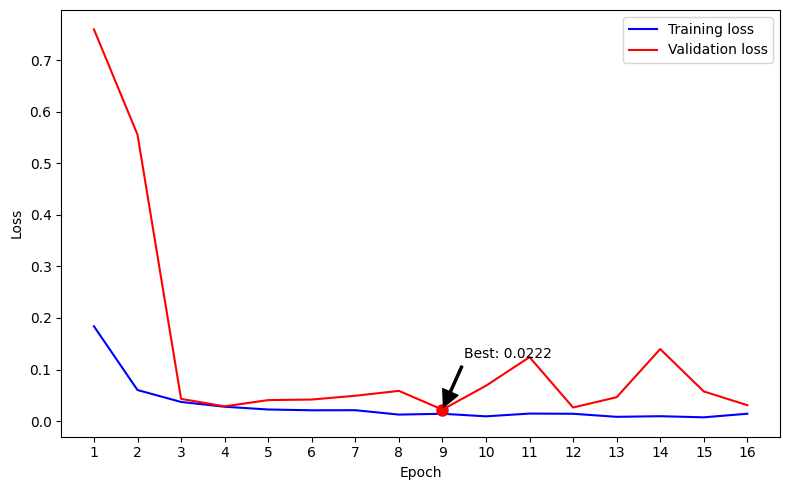

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def visualise_training(model):
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]
	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, 'b-', label='Training loss')
	plt.plot(epochs, dev_losses, 'r-', label='Validation loss')
	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, 'ro', markersize=8)
	plt.annotate(
		f'Best: {best_loss:.4f}',
		xy=(best_epoch, best_loss),
		xytext=(best_epoch + 0.5, best_loss + 0.1),
		arrowprops=dict(facecolor='black', shrink=0.05, width=1.5)
	)
	plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
	plt.tight_layout()
	plt.show()

def compute_metrics(y_true, y_pred):
	y_true, y_pred = y_true.cpu().numpy(), (y_pred.cpu().numpy() > 0.5)
	acc = accuracy_score(y_true, y_pred)
	precision = precision_score(y_true, y_pred, zero_division=0)
	recall = recall_score(y_true, y_pred)
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
	tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
	fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
	return {
		"accuracy": float(round(acc, 5)),
		"precision": float(round(precision, 5)),
		"TPR": float(round(tpr, 5)),
		"FPR": float(round(fpr, 5))
	}

def evaluate_model(model, test_loader):
	model.eval()
	y_true, y_pred = [], []
	with torch.no_grad():
		for images, labels in test_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			outputs = model(images)
			y_true.append(labels)
			y_pred.append(outputs)
	y_true = torch.cat(y_true, dim=0)
	y_pred = torch.cat(y_pred, dim=0)
	metrics = compute_metrics(y_true, y_pred)
	print(f"Test Metrics: {{'accuracy': {metrics['accuracy']:.5f}, "
		f"'precision': {metrics['precision']:.5f}, "
		f"'TPR': {metrics['TPR']:.5f}, "
		f"'FPR': {metrics['FPR']:.5f}}}")

model_ = MNV3S().to(DEVICE)
visualise_training(model_)

model_.load_state_dict(torch.load(os.path.join(MODELS_PATH, model_.id, "best.pth")))
evaluate_model(model_, test_loader)